Exploring Decision Trees
========================

Use a decision tree classifier to create a simplified model exploring the "Sex", "Age" and "Fare Per Person" features.

In [1]:
# set up code and dataframe with training data
import pandas as pd
import numpy as np
import statistics as st

import sklearn.metrics as ms
import sklearn.tree as tr
import sklearn.model_selection as mds

from scipy import interpolate
import matplotlib.pyplot as plt

datestamp = "20250226.185554"
df_ = pd.read_csv(f"../data/kaggle/train.clean.{datestamp}.csv")
print(df_.shape)

(891, 55)


In [2]:
#x_colnames = [ "P3orDeadTitle", "HasCabin", "AgeImputed", "FarePerPerson", "Pclass", "CabinF" ]
#x_colnames = [ "P3orDeadTitle", "HasCabin", "Pclass", "TitleOrd", "Mr", "CabinOrd", 
#               "FarePerPerson", "AgeImputed", "EmbarkOrd", "SexOrd" ]
x_colnames = [ "P3orDeadTitle", "IsMale", "AgeImputed", "GroupSize", "Pclass" ]
y_colname = [ "Survived" ]

X = df_[ x_colnames ]
y = df_[ y_colname ].values

print(X.info())

# Assuming you have your features in X and your target variable in y
X_train, X_test, y_train, y_test = mds.train_test_split(X, y, test_size=0.2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   P3orDeadTitle  891 non-null    int64  
 1   IsMale         891 non-null    int64  
 2   AgeImputed     891 non-null    float64
 3   GroupSize      891 non-null    int64  
 4   Pclass         891 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 34.9 KB
None


In [3]:
n_folds = 6
s_scoring = "balanced_accuracy"

param_dist = {
    'max_leaf_nodes': [ 6 ],
    'max_depth': [ 4 ],
    'min_samples_split': [ 25 ],
    'min_samples_leaf': [ 15 ]
} 


# Create a decision tree classifier
clf = tr.DecisionTreeClassifier(criterion='entropy')

grid_search = mds.GridSearchCV( estimator=clf,
                                param_grid=param_dist,
                                cv=n_folds,
                                scoring=s_scoring,
                                n_jobs=-1 )

# Train the classifier
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
model       = grid_search.best_estimator_

print(best_params)
print()

{'max_depth': 4, 'max_leaf_nodes': 6, 'min_samples_leaf': 15, 'min_samples_split': 25}



In [4]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame(
    {'Feature': x_colnames, 'Gini Importance': importances} ).sort_values(
         'Gini Importance', ascending=False)
print(feature_imp_df)

         Feature  Gini Importance
0  P3orDeadTitle         0.711158
1         IsMale         0.183340
4         Pclass         0.056100
3      GroupSize         0.049402
2     AgeImputed         0.000000


In [5]:
print(tr.export_text(model, show_weights=True, feature_names=x_colnames, class_names=['Dead', 'Alive']))

|--- P3orDeadTitle <= 0.50
|   |--- IsMale <= 0.50
|   |   |--- weights: [7.00, 134.00] class: Alive
|   |--- IsMale >  0.50
|   |   |--- weights: [8.00, 13.00] class: Alive
|--- P3orDeadTitle >  0.50
|   |--- IsMale <= 0.50
|   |   |--- GroupSize <= 4.50
|   |   |   |--- weights: [37.00, 53.00] class: Alive
|   |   |--- GroupSize >  4.50
|   |   |   |--- weights: [18.00, 2.00] class: Dead
|   |--- IsMale >  0.50
|   |   |--- Pclass <= 1.50
|   |   |   |--- weights: [53.00, 28.00] class: Dead
|   |   |--- Pclass >  1.50
|   |   |   |--- weights: [314.00, 45.00] class: Dead



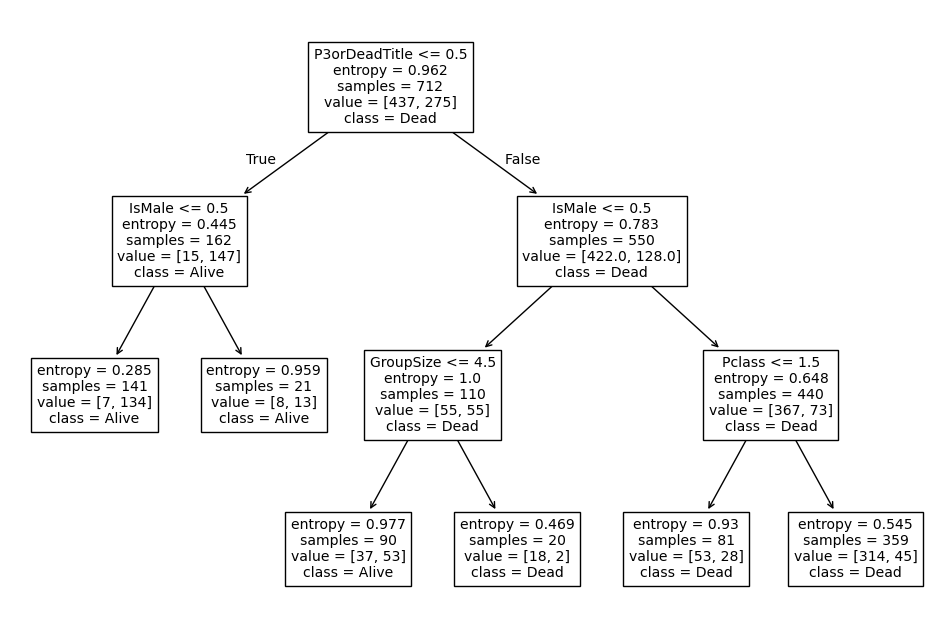

In [6]:
plt.figure(figsize=(12, 8))
tr.plot_tree(model, feature_names=x_colnames, class_names=['Dead', 'Alive'])
plt.show()

In [7]:
l_raw_scores = mds.cross_val_score(model, X_test, y_test, scoring=s_scoring, cv=n_folds)
l_scores = [ round(i, 2) for i in l_raw_scores ]

mean_score = round(st.mean(l_scores), 3)
std_score = round(st.stdev(l_scores), 3)

print(f"{n_folds}-fold {s_scoring} mean: {mean_score}, stdev: {std_score}")
print(f"  each: {l_scores}")

6-fold balanced_accuracy mean: 0.73, stdev: 0.052
  each: [np.float64(0.76), np.float64(0.78), np.float64(0.71), np.float64(0.72), np.float64(0.64), np.float64(0.77)]


In [8]:
# calculate test ROC curve
y_test_preds_proba  = model.predict_proba(X_test)

test_fpr, test_tpr, test_thresh = ms.roc_curve(y_test, y_test_preds_proba[:,1])
test_roc_auc = ms.auc(test_fpr, test_tpr)

# Calculate the geometric mean
test_gmeans = np.sqrt(test_tpr * (1 - test_fpr))

# Locate the index of the largest gmean
test_index = np.argmax(test_gmeans)
test_threshold = test_thresh[test_index]

test_tpr_intrp = interpolate.interp1d(test_thresh, test_tpr)
test_fpr_intrp = interpolate.interp1d(test_thresh, test_fpr)

print(f"Test AUC {round(test_roc_auc,3)}")
print(f"Test optimal threshold {round(test_threshold,3)} at " \
      f"tpr: {np.round(test_tpr_intrp(test_threshold),3)}, " \
      f"fpr: {np.round(test_fpr_intrp(test_threshold),3)}")

Test AUC 0.847
Test optimal threshold 0.589 at tpr: 0.701, fpr: 0.116


In [9]:
threshold = test_threshold
#threshold = 0.6

In [10]:
y_test_preds_proba = model.predict_proba(X_test)
y_test_preds = (y_test_preds_proba[:,1] > threshold).astype(int)

tn, fp, fn, tp = ms.confusion_matrix(y_test, y_test_preds).ravel()
print(f"Confusion Matrix, at Threshold {threshold:.3f}")
print(f"  tn {tn:<3}  fp {fp:<3}")
print(f"  fn {fn:<3}  tp {tp:<3}")
print()

bal_acc   = round( ms.balanced_accuracy_score( y_test, y_test_preds ), 3 )
precision = round( ms.precision_score( y_test, y_test_preds ), 3 )
recall    = round( ms.recall_score( y_test, y_test_preds ), 3 )
f1        = round( ms.f1_score( y_test, y_test_preds, average='micro' ), 3 )

s_scores = f"Bal Acc: {bal_acc}, Pre: {precision}, Rec: {recall}, F1 Micro: {f1}"
print(s_scores)

Confusion Matrix, at Threshold 0.589
  tn 110  fp 2  
  fn 36   tp 31 

Bal Acc: 0.722, Pre: 0.939, Rec: 0.463, F1 Micro: 0.788


In [11]:
df_test = pd.read_csv(f"../data/kaggle/test.clean.{datestamp}.csv")

y_proba = model.predict_proba(df_test[x_colnames])
y_preds = (y_proba[:,1] > threshold).astype(int)

df_test["SurvivedProbability"] = y_proba[:,1]
df_test["Survived"] = y_preds

df_sub = df_test[ (df_test[ "Mr" ] == 0)]

df_sub[["Pclass", "Name", "Sex", "AgeImputed", "AgeRobust", "FppRobust", "SurvivedProbability", "Survived"]].head(10)

df_test[["PassengerId", "Survived"]].to_csv(f"../data/kaggle/submit.decisions.csv", index=False)